In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import c

import pickle

# Import Pickle Dictionary

In [2]:
with open("GPS_fit_results.pkl", "rb") as f:
    dict_fit = pickle.load(f)

data_names = dict_fit["values"].keys()
parameters_names = dict_fit["values"]["rpN"].keys()

In [3]:
with open("GPS_noise_analysis.pkl", "rb") as f:
    dict_data = pickle.load(f)

rpN_data = dict_data["rpN"]["clean_data"]
rpE_data = dict_data["rpE"]["clean_data"]
rpD_data = dict_data["rpD"]["clean_data"]
roll_data = dict_data["roll"]["clean_data"]
yaw_data = dict_data["yaw"]["clean_data"]

In [4]:
config_index = 3
config_indices = [12, 3, 37]

seed = 0
np.random.seed(seed)

In [5]:
def noise_model(x, A_white, f_knee, alpha, f_min=1e-6):
    f = np.maximum(np.abs(x), f_min)
    return A_white**2 * (1.0 + (f_knee / f) ** alpha)

# Test

## Compute Covariance Matrix

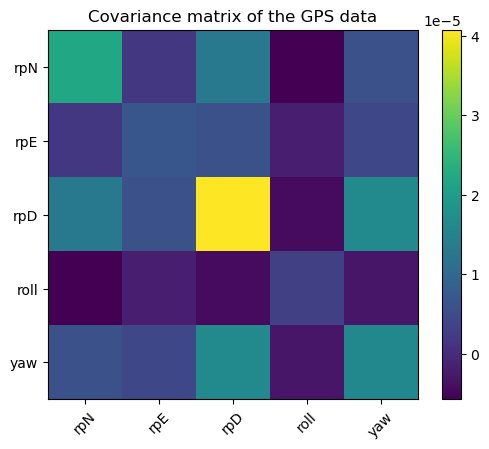

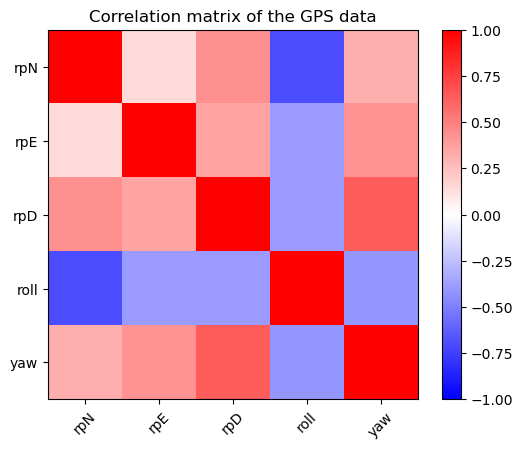

In [6]:
data = np.array([rpN_data[config_index], rpE_data[config_index], rpD_data[config_index], roll_data[config_index], yaw_data[config_index]])
std_ = np.std(data, axis=1)
cov = np.cov(data, rowvar=True)
corr = np.corrcoef(data, rowvar=True)

plt.imshow(cov)
plt.colorbar()
plt.xticks(np.arange(len(data_names)), data_names, rotation=45)
plt.yticks(np.arange(len(data_names)), data_names)
plt.title("Covariance matrix of the GPS data")
plt.show()

plt.imshow(corr, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks(np.arange(len(data_names)), data_names, rotation=45)
plt.yticks(np.arange(len(data_names)), data_names)
plt.title("Correlation matrix of the GPS data")
plt.show()

## Test Uncertainties from STD

In [7]:
std_rpN, std_rpE, std_rpD = dict_fit["standard_deviation"]["rpN"][config_index], dict_fit["standard_deviation"]["rpE"][config_index], dict_fit["standard_deviation"]["rpD"][config_index]
std_roll, std_yaw = dict_fit["standard_deviation"]["roll"][config_index], dict_fit["standard_deviation"]["yaw"][config_index]

sigma_std_pos = np.sqrt(std_rpN**2 + std_rpE**2 + std_rpD**2)
sigma_std_ang = np.sqrt(std_roll**2 + std_yaw**2)

print(f"RMS 3D-error = {sigma_std_pos:.3f} cm")
print(f"RMS angular error = {sigma_std_ang:.3f} deg")

RMS 3D-error = 0.648 cm
RMS angular error = 0.250 deg


## Test Uncertainties from PS

### Test Normalization Numpy FFT

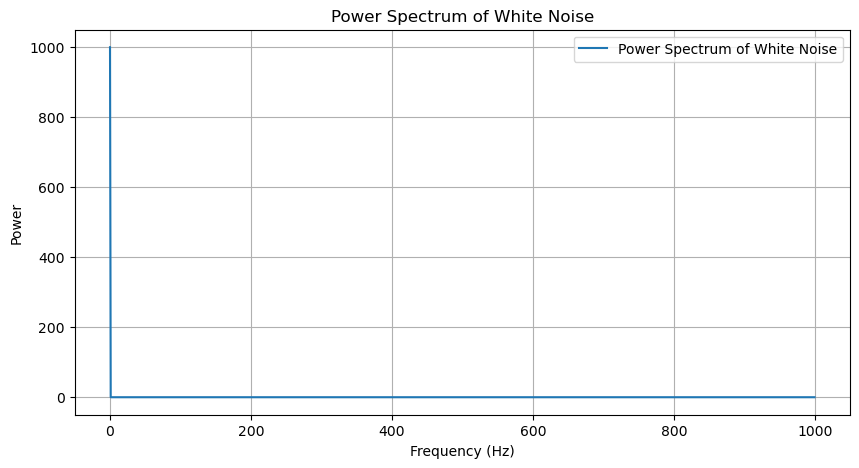

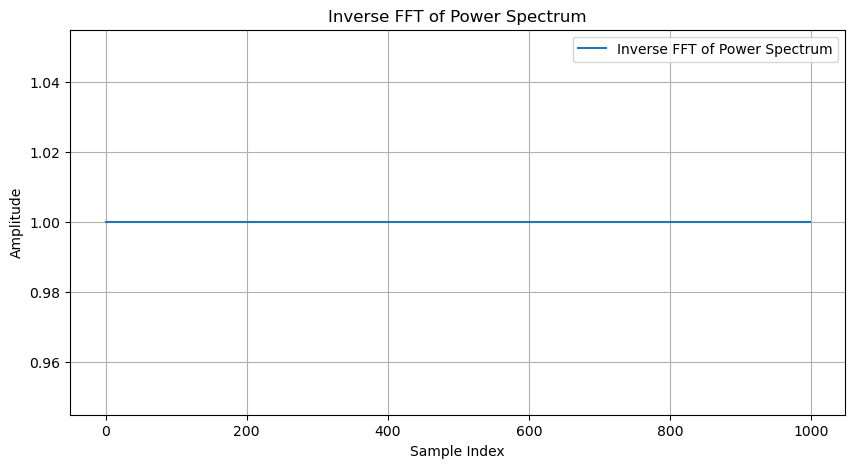

Normalization Factor: 1.0


In [8]:
white_noise = np.ones(1000)

ps = np.fft.fft(white_noise)
ps = np.abs(ps) ** 2
ps = ps / len(ps)

plt.figure(figsize=(10, 5))
plt.plot(ps, label="Power Spectrum of White Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of White Noise")
plt.legend()
plt.grid()
plt.show()

noise = np.fft.ifft(ps)
noise = noise[1:]
plt.figure(figsize=(10, 5))
plt.plot(noise.real, label="Inverse FFT of Power Spectrum")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Inverse FFT of Power Spectrum")
plt.legend()
plt.grid()
plt.show()

print("Normalization Factor:", np.mean(noise.real) / np.mean(white_noise))

### Test Uncertainties

In [9]:
sampling_rate = 8  # Hz
timestep = 1 / sampling_rate  # Time step in seconds
f_nyq = sampling_rate / 2  # Nyquist frequency
f_min = 1 / (timestep * len(rpN_data[0]))  # Minimum frequency

# Frequencies for the power spectrum
freqs = np.linspace(f_min, f_nyq, 20000)

In [10]:
sigma2 = np.empty((3, len(data_names)))
std_data = np.empty((3, len(data_names)))

for iconfig, config_index in enumerate(config_indices):
    print(f"\nConfiguration Index: {config_index}")
    print("=" * 60)
    for i, data_name in enumerate(data_names):
        A_white = dict_fit["values"][data_name]["A_white"][config_index]
        f_knee = dict_fit["values"][data_name]["f_knee"][config_index]
        alpha = dict_fit["values"][data_name]["alpha"][config_index]

        # Power spectrum calculation
        S = A_white**2 * (1 + np.abs(f_knee / freqs) ** alpha)
        # Integrate
        sigma2_val = np.trapz(S, freqs)
        std_val = np.sqrt(sigma2_val)

        if data_name in ["rpN", "rpE", "rpD"]:
            unit = "m"
        elif data_name in ["roll", "yaw"]:
            unit = "deg"
        else:
            unit = "unknown"

        sigma2[iconfig, i] = sigma2_val
        std_data[iconfig, i] = dict_fit['standard_deviation'][data_name][config_index] / 100

        print(f"{data_name:>6} | std (PS) = {std_val:.4e} {unit} | std = {std_data[iconfig, i]:.4e} {unit}")

    print("=" * 60)


Configuration Index: 12
   rpN | std (PS) = 1.7750e-02 m | std = 3.0020e-03 m
   rpE | std (PS) = 7.1335e-03 m | std = 1.7864e-03 m
   rpD | std (PS) = 1.3220e-02 m | std = 2.1307e-03 m
  roll | std (PS) = 6.3821e-03 deg | std = 5.9903e-04 deg
   yaw | std (PS) = 7.1491e-03 deg | std = 8.1497e-04 deg

Configuration Index: 3
   rpN | std (PS) = 1.2603e-02 m | std = 4.6857e-03 m
   rpE | std (PS) = 1.0334e-02 m | std = 2.5729e-03 m
   rpD | std (PS) = 1.9451e-02 m | std = 3.6566e-03 m
  roll | std (PS) = 4.1692e-03 deg | std = 9.9899e-04 deg
   yaw | std (PS) = 9.3150e-03 deg | std = 2.2937e-03 deg

Configuration Index: 37
   rpN | std (PS) = 1.5409e-02 m | std = 5.2996e-03 m
   rpE | std (PS) = 1.1949e-02 m | std = 5.5120e-03 m
   rpD | std (PS) = 1.7427e-02 m | std = 2.8445e-03 m
  roll | std (PS) = 7.9130e-03 deg | std = 4.3201e-03 deg
   yaw | std (PS) = 1.7759e-02 deg | std = 4.1674e-03 deg


In [11]:
sigma_ps_pos = np.sqrt(np.sum(sigma2[:3]))
sigma_ps_ang = np.sqrt(np.sum(sigma2[3:]))

print(f"Uncertainty for antenna 1 position at config {config_index}: {sigma_ps_pos * 100:.3f} cm")
print(f"Uncertainty for antenna 2 angle at config {config_index}: {np.degrees(sigma_ps_ang):.3f} deg")

Uncertainty for antenna 1 position at config 37: 4.942 cm
Uncertainty for antenna 2 angle at config 37: 0.000 deg


## Test Correlated Noise

### White Noise

In [12]:
def generate_correlated_noise(corr_matrix, std_devs, n_samples):
    C = np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

    return np.random.multivariate_normal(
        mean=np.zeros(C.shape[0]), 
        cov=C, 
        size=n_samples,
    )

(5, 5000)


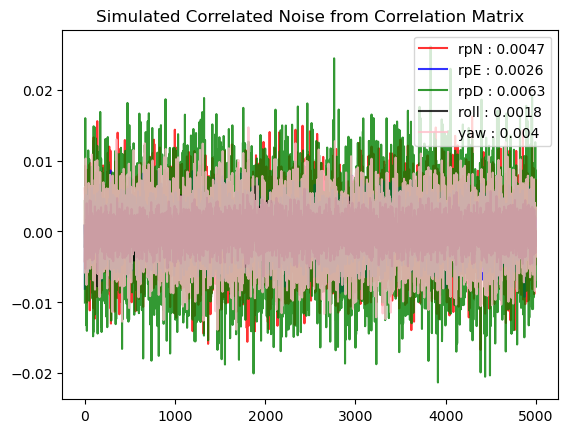

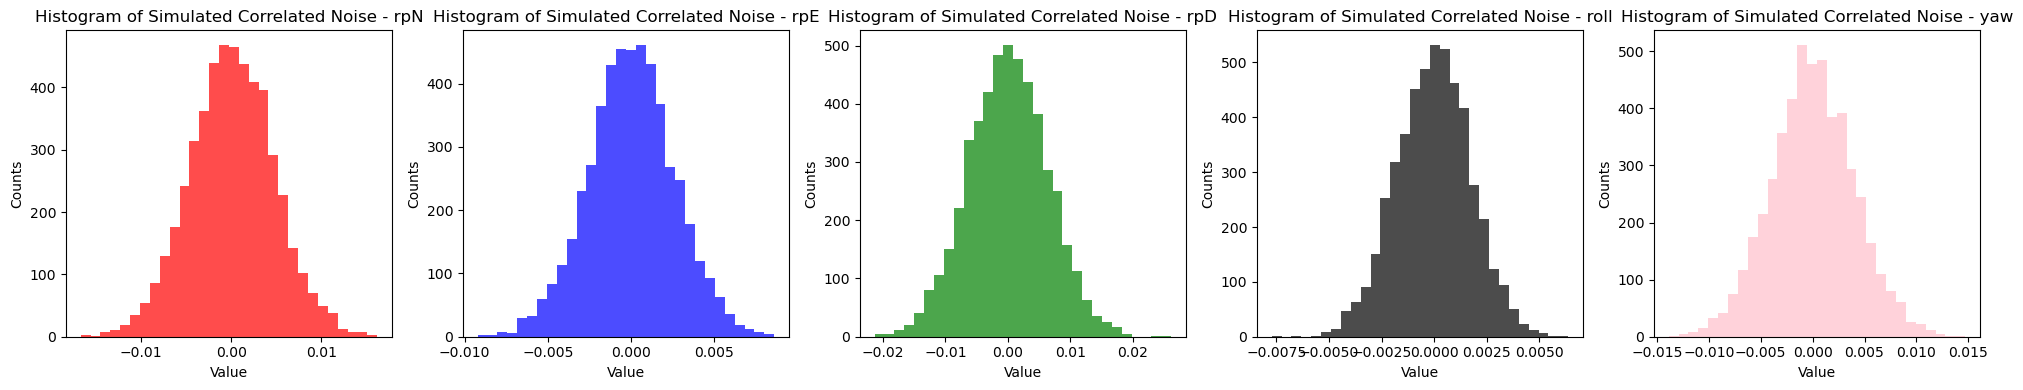

In [13]:
test_corr_noise = generate_correlated_noise(corr, std_, 5000).T
print(test_corr_noise.shape)

color = ["red", "blue", "green", "black", "pink"]

for i, idata_name in enumerate(data_names):
    if i<6:
        plt.plot(test_corr_noise[i], label=idata_name + f" : {round(np.std(test_corr_noise[i]), 4)}", alpha=0.8, color=color[i])
plt.legend()
plt.title("Simulated Correlated Noise from Correlation Matrix")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, idata_name in enumerate(data_names):
    if i<5:
        axs[i].hist(test_corr_noise[i], bins=30, alpha=0.7, color=color[i])
        axs[i].set_title(f"Histogram of Simulated Correlated Noise - {idata_name}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.show()

### Power Spectrum

In [14]:
def generate_correlated_noise_from_ps(R, n_samples, measured_stds, fs=sampling_rate, eps_reg=1e-14):
    n_data = R.shape[0]
    N = n_samples
    freqs = np.fft.fftfreq(N, 1.0/fs)
    df = fs / N

    # --- 1) compute model PSD on grid for each channel ---
    S_model = np.zeros((n_data, N), dtype=float)
    for i, name in enumerate(data_names):
        fp = dict_fit["values"][name]
        f_abs = np.maximum(np.abs(freqs), f_min)   # avoid f=0 singularity
        S_vals = noise_model(f_abs,
                             A_white=fp["A_white"][config_index],
                             f_knee=fp["f_knee"][config_index],
                             alpha=fp["alpha"][config_index])
        S_vals = np.asarray(S_vals, dtype=float)

        # guard against NaN/inf
        S_vals[~np.isfinite(S_vals)] = 0.0
        S_model[i, :] = S_vals

    # theoretical model variances (before scaling)
    var_model = np.sum(S_model, axis=1) * df        # length n_data

    # target variances from measured std
    target_var = np.asarray(measured_stds, dtype=float)**2

    # compute per-channel scale factors (guard divide-by-zero)
    scale = np.ones(n_data)
    mask_nonzero = var_model > 0
    scale[mask_nonzero] = target_var[mask_nonzero] / var_model[mask_nonzero]
    # if some var_model==0 (odd), keep scale=1 (or set to large number if you want)
    # apply scale to PSD: S_scaled = scale[:,None] * S_model
    S_scaled = S_model * scale[:, np.newaxis]

    # --- generate multivariate colored noise using full cross-spectral factorization ---
    # 1) independent white noise
    white = np.random.randn(n_data, N)
    W = np.fft.fft(white, axis=1)

    # ensure R is PSD
    R = (np.array(R, float) + np.array(R, float).T) / 2.0
    wR, VR = np.linalg.eigh(R)
    wR = np.clip(wR, 0.0, None)
    R = (VR * wR[np.newaxis, :]) @ VR.T

    X = np.zeros_like(W, dtype=np.complex128)

    for k in range(N):
        # S_vec for this freq using S_scaled
        S_vec = S_scaled[:, k]
        # sqrt diagonal
        sqrtS = np.sqrt(np.maximum(S_vec, 0.0))
        D = np.diag(sqrtS)
        S_mat = D @ R @ D
        S_mat = (S_mat + S_mat.T.conj()) / 2.0
        S_mat += eps_reg * np.eye(n_data)

        # eigen-decomp (small matrix)
        w, V = np.linalg.eigh(S_mat)
        w = np.clip(w, 0.0, None)
        sqrt_diag = np.sqrt(w * df * N + 0.0)
        M = (V * sqrt_diag[np.newaxis, :]) @ V.conj().T

        X[:, k] = M @ W[:, k]

    x = np.fft.ifft(X, axis=1).real

    return x

def generate_correlated_noise_from_ps_test(corr_matrix, n_samples, std, fs=sampling_rate):
    R = corr_matrix
    
    n_data = R.shape[0]
    N = n_samples
    freqs = np.fft.fftfreq(N, 1.0/fs)
    df = fs / N
    
    # 1) Build white noise
    white = np.random.randn(n_data, N)
    W = np.fft.fft(white, axis=1)
    
    # 2) Build noise PSD
    # Build PS
    S_model = np.zeros((n_data, N), dtype=float)
    for i, name in enumerate(data_names):
        fp = dict_fit["values"][name]        
        S_model[i, :] = noise_model(freqs,
                             A_white=fp["A_white"][config_index],
                             f_knee=fp["f_knee"][config_index],
                             alpha=fp["alpha"][config_index])
    
    # Scale PS
    var_model = np.sum(S_model, axis=1) * df
    scale = (std ** 2) / var_model
    S = S_model * scale[:, None]
        
    # 3) Per frequency shaping + correlation
    # D = np.sqrt(S)
    # S = D @ R @ D
    # eigvals, eigvecs = np.linalg.eigh(S)
    # X = eigvecs @ np.sqrt(eigvals) @ eigvecs.T
    
    X = np.zeros_like(W, dtype=np.complex128)
    for k, f in enumerate(freqs):
        D = np.diag(np.sqrt(S[:, k]))
        S_mat = D @ R @ D
        eigvals, eigvecs = np.linalg.eigh(S_mat)
        M = (eigvecs * np.sqrt((eigvals) * df * N)[None, :]) @ eigvecs.T
        X[:, k] = M @ W[:, k]
        
    # 4) Back to time domain
    x = np.fft.ifft(X, axis=1).real
    
    return x

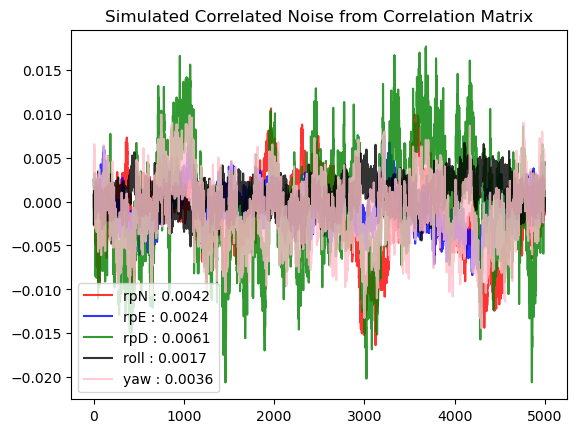

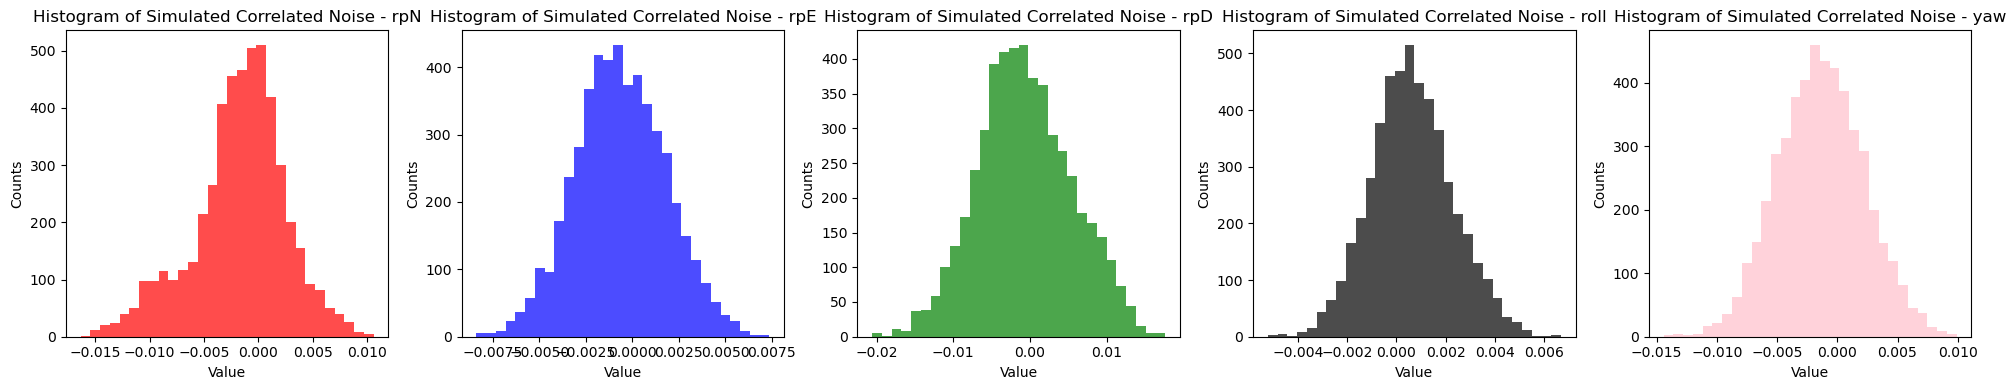

In [15]:
corr_noise = generate_correlated_noise_from_ps(corr, 5000, std_)

for i, idata_name in enumerate(data_names):
    if i<6:
        plt.plot(corr_noise[i], label=idata_name + f" : {round(np.std(corr_noise[i]), 4)}", alpha=0.8, color=color[i])
plt.legend()
plt.title("Simulated Correlated Noise from Correlation Matrix")
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, idata_name in enumerate(data_names):
    if i<5:
        axs[i].hist(corr_noise[i], bins=30, alpha=0.7, color=color[i])
        axs[i].set_title(f"Histogram of Simulated Correlated Noise - {idata_name}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Counts")
plt.tight_layout()
plt.show()

# Calibration Source Beam from position and orientation uncertainties 

For this work, we don't want to perform accurate estimation but only order of magnitude.
So, we will assume that the two antennas are perfectly aligned with the calibration source's line-of-sight, which is pointing exactly at the center of QUBIC, and considering that the system GPS + Calibration Source is perfectly fixed together.

Under these hypotheses:
* The uncertainty on the calibration source position is the uncertainty on the antenna 1,
* The uncertainty on the angels between antennas 1 & 2 is the uncertainty on the calibration source orientation.

In [16]:
qubic_height = 4  # m
calsource_height = 48.6  # m
ground_distance = 38.44  # m

distance_qubic_calsource = np.sqrt((calsource_height - qubic_height) ** 2 + ground_distance**2)

print(f"Distance between QUBIC and calibration source: {distance_qubic_calsource:.2f} m")

Distance between QUBIC and calibration source: 58.88 m


## Gaussian Beam

Spot size : $w(z) = w_0 \sqrt{1 + (z/z_R)^2}$, where $z_R = \pi w_0^2 n / \lambda \\$

Gaussian Beam Intensity : $\\$
$I(r, z) = I_0 (\frac{w_0}{w(z)})^2 exp(-\frac{2r^2}{w^2(z)})$

In [17]:
def gaussian_beam(r, z, w0, I0=1.0):
    """
    Calculate the Gaussian beam intensity at a distance r from the center
    and at a distance z from the beam waist.

    Parameters:
    r : radial distance from the center (m)
    z : distance from the beam waist (m)
    w0 : beam waist radius (m)
    I0 : peak intensity at the beam waist (W/m²)

    Returns:
    I : intensity at distance r and z (W/m²)
    """
    z_R = np.pi * w0**2 / c  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam radius at distance z
    return I0 * (w0 / w_z) ** 2 * np.exp(-2 * r**2 / w_z**2)

In [18]:
freq = 150e9  # Frequency in Hz
wavelength = c / freq  # Wavelength in meters
FWHM = 13  # degrees
FWHM_rad = np.radians(FWHM)

# Calculate the beam waist radius w0
theta_0 = FWHM_rad / (2 * np.sqrt(2 * np.log(2)))
w0 = wavelength / (np.pi * theta_0)
print(f"Beam waist radius w0 = {w0:.3f} m")

Beam waist radius w0 = 0.007 m


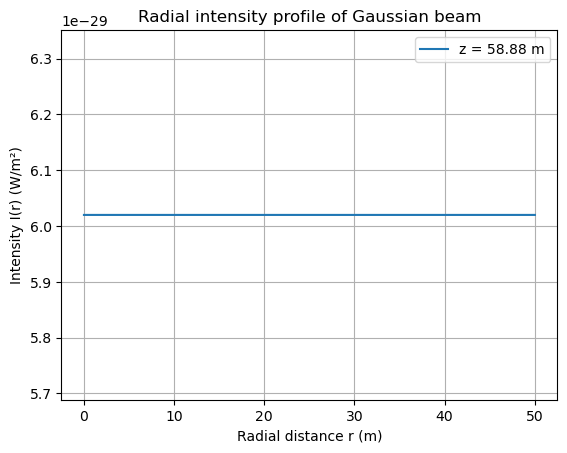

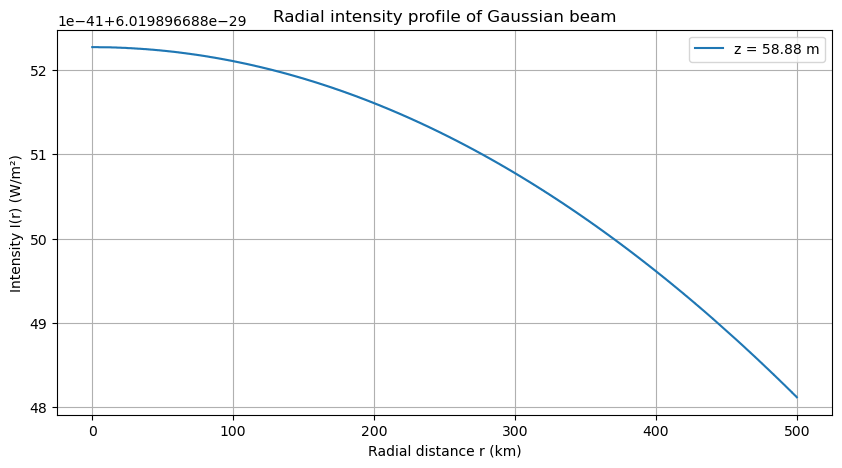

In [19]:
r = np.linspace(1e-3, 50, 10000)
z = distance_qubic_calsource.round(2)  # Distance from the beam waist
I0 = 1.0

beam = gaussian_beam(r, z, w0, I0)

plt.figure()
plt.plot(r, beam, label=f"z = {z} m")
plt.xlabel("Radial distance r (m)")
plt.ylabel("Intensity I(r) (W/m²)")
plt.title("Radial intensity profile of Gaussian beam")
plt.legend()
plt.grid()
plt.show()

r = np.linspace(1e-3, 500000, 10000)

beam = gaussian_beam(r, z, w0, I0)

plt.figure(figsize=(10, 5))
plt.plot(r / 1000, beam, label=f"z = {z} m")
plt.xlabel("Radial distance r (km)")
plt.ylabel("Intensity I(r) (W/m²)")
plt.title("Radial intensity profile of Gaussian beam")
plt.legend()
plt.grid()
plt.show()

# Modification of the beam due to Calsource uncertainties

In [20]:
N = int(1e6)
name_config = ["Optimistic", "Realistic", "Pessimistic"]
labels = [r"$\delta_x$ (mm)", r"$\delta_y$ (mm)", r"$\delta_z$ (mm)", r"$\delta_{el}$ ($1e^{-3}$ deg)", r"$\delta_{az}$ ($1e^{-3}$ deg)"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
sigma_colors = ["#76b7b2", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5"]
config_indices = [12, 3, 37]

corr = []

for i in config_indices :
    data = np.array([rpN_data[i], rpE_data[i], rpD_data[i], roll_data[i], yaw_data[i]])
    corr.append(np.corrcoef(data, rowvar=True))

## Correlated Noise

In [21]:
def generate_correlated_noise(corr_matrix, std_devs, n_samples):
    C = np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

    return np.random.multivariate_normal(
        mean=np.zeros(C.shape[0]), 
        cov=C, 
        size=n_samples,
    )

# def generate_correlated_noise_from_ps(corr_matrix, std, n_samples, fs=sampling_rate):
#     n_data = corr_matrix.shape[0]
    
#     # generate white noise with correlation
#     white_noise = np.random.multivariate_normal(mean = np.zeros(n_data), cov=corr_matrix, size=n_samples).T
    
#     # 
#     correlated_noise = np.zeros((n_data, n_samples))
#     freqs = np.fft.fftfreq(n_samples, 1/fs)
#     df = fs / n_samples
    
#     for i,idata in enumerate(data_names):
#         fit_param = dict_fit["values"][idata]
#         amp = np.sqrt(noise_model(np.abs(freqs), A_white=fit_param["A_white"][config_index], f_knee=fit_param["f_knee"][config_index], alpha=fit_param["alpha"][config_index]) * df * n_samples)
        
#         amp[0] = amp[1] if amp[0] == np.inf else amp[0]
        
#         white_fft = np.fft.fft(white_noise[i])
#         shaped_fft = white_fft * amp
        
#         correlated_noise[i] = np.real(np.fft.ifft(shaped_fft))
    
#     norm_factor = std / np.std(correlated_noise, axis=1)
#     return correlated_noise * norm_factor[:, np.newaxis]

def generate_correlated_noise_from_ps(R, n_samples, measured_stds, fs=sampling_rate, eps_reg=1e-14):
    n_data = R.shape[0]
    N = n_samples
    freqs = np.fft.fftfreq(N, 1.0/fs)
    df = fs / N

    # --- 1) compute model PSD on grid for each channel ---
    S_model = np.zeros((n_data, N), dtype=float)
    for i, name in enumerate(data_names):
        fp = dict_fit["values"][name]
        f_abs = np.maximum(np.abs(freqs), f_min)   # avoid f=0 singularity
        S_vals = noise_model(f_abs,
                             A_white=fp["A_white"][config_index],
                             f_knee=fp["f_knee"][config_index],
                             alpha=fp["alpha"][config_index])
        S_vals = np.asarray(S_vals, dtype=float)

        # guard against NaN/inf
        S_vals[~np.isfinite(S_vals)] = 0.0
        S_model[i, :] = S_vals

    # theoretical model variances (before scaling)
    var_model = np.sum(S_model, axis=1) * df        # length n_data

    # target variances from measured std
    target_var = np.asarray(measured_stds, dtype=float)**2

    # compute per-channel scale factors (guard divide-by-zero)
    scale = np.ones(n_data)
    mask_nonzero = var_model > 0
    scale[mask_nonzero] = target_var[mask_nonzero] / var_model[mask_nonzero]
    # if some var_model==0 (odd), keep scale=1 (or set to large number if you want)
    # apply scale to PSD: S_scaled = scale[:,None] * S_model
    S_scaled = S_model * scale[:, np.newaxis]

    # --- generate multivariate colored noise using full cross-spectral factorization ---
    # 1) independent white noise
    white = np.random.randn(n_data, N)
    W = np.fft.fft(white, axis=1)

    # ensure R is PSD
    R = (np.array(R, float) + np.array(R, float).T) / 2.0
    wR, VR = np.linalg.eigh(R)
    wR = np.clip(wR, 0.0, None)
    R = (VR * wR[np.newaxis, :]) @ VR.T

    X = np.zeros_like(W, dtype=np.complex128)

    for k in range(N):
        # S_vec for this freq using S_scaled
        S_vec = S_scaled[:, k]
        # sqrt diagonal
        sqrtS = np.sqrt(np.maximum(S_vec, 0.0))
        D = np.diag(sqrtS)
        S_mat = D @ R @ D
        S_mat = (S_mat + S_mat.T.conj()) / 2.0
        S_mat += eps_reg * np.eye(n_data)

        # eigen-decomp (small matrix)
        w, V = np.linalg.eigh(S_mat)
        w = np.clip(w, 0.0, None)
        sqrt_diag = np.sqrt(w * df * N + 0.0)
        M = (V * sqrt_diag[np.newaxis, :]) @ V.conj().T

        X[:, k] = M @ W[:, k]

    x = np.fft.ifft(X, axis=1).real

    return x

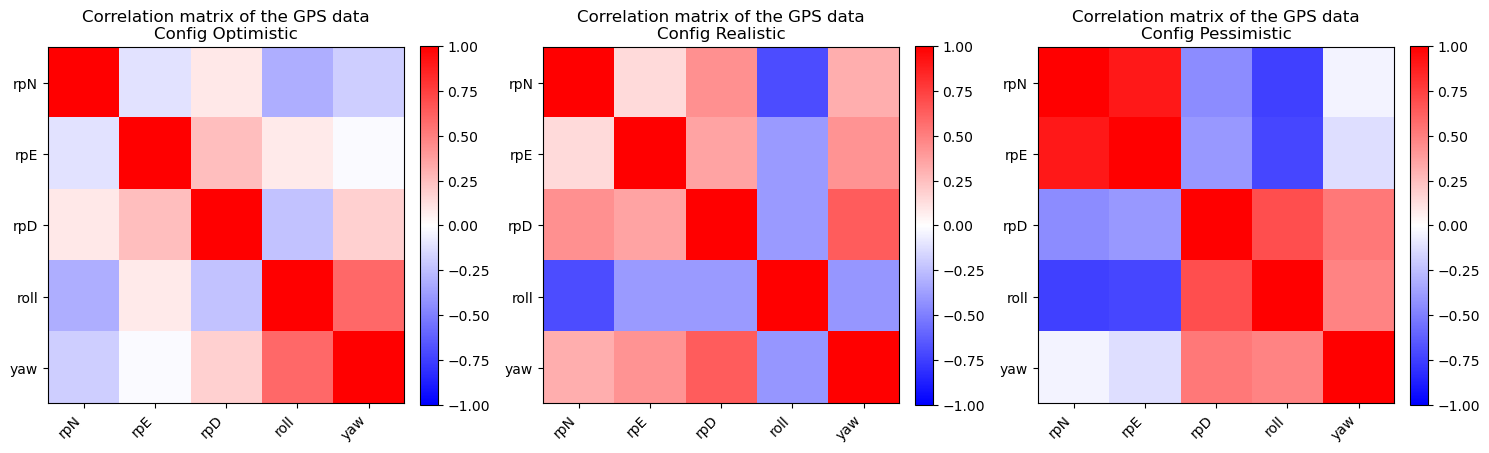

In [22]:
fig, axes = plt.subplots(1, len(config_indices), figsize=(15, 5))

correlated_noise_white, correlated_noise_ps = [], []

for i, config_index in enumerate(config_indices):
    # Convert to mm and 1e-3 deg
    correlated_noise_white.append(1000 * generate_correlated_noise(corr[i], std_data[i], N).T)
    correlated_noise_ps.append(1000 * generate_correlated_noise_from_ps(corr[i], N, std_data[i]))

    im = axes[i].imshow(corr[i], vmin=-1, vmax=1, cmap="bwr", aspect='equal')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    axes[i].set_xticks(np.arange(len(data_names)))
    axes[i].set_yticks(np.arange(len(data_names)))
    axes[i].set_xticklabels(data_names, rotation=45, ha='right')
    axes[i].set_yticklabels(data_names)
    axes[i].set_title(f"Correlation matrix of the GPS data\nConfig {name_config[i]}")
plt.tight_layout()
plt.show()

## Correlated Noise Plots

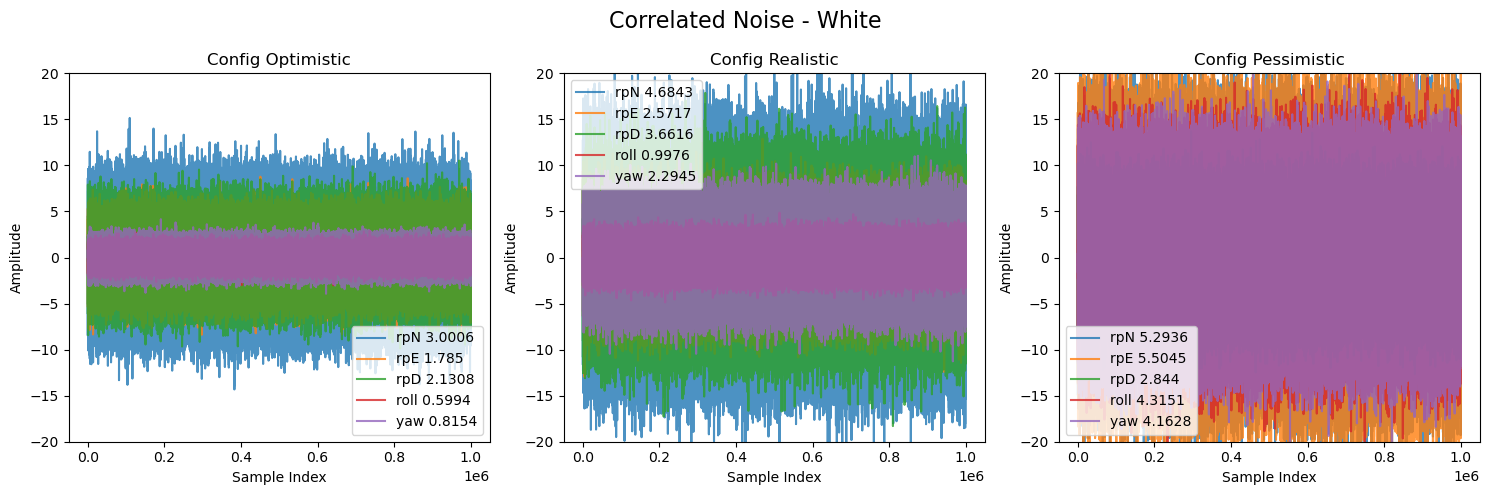

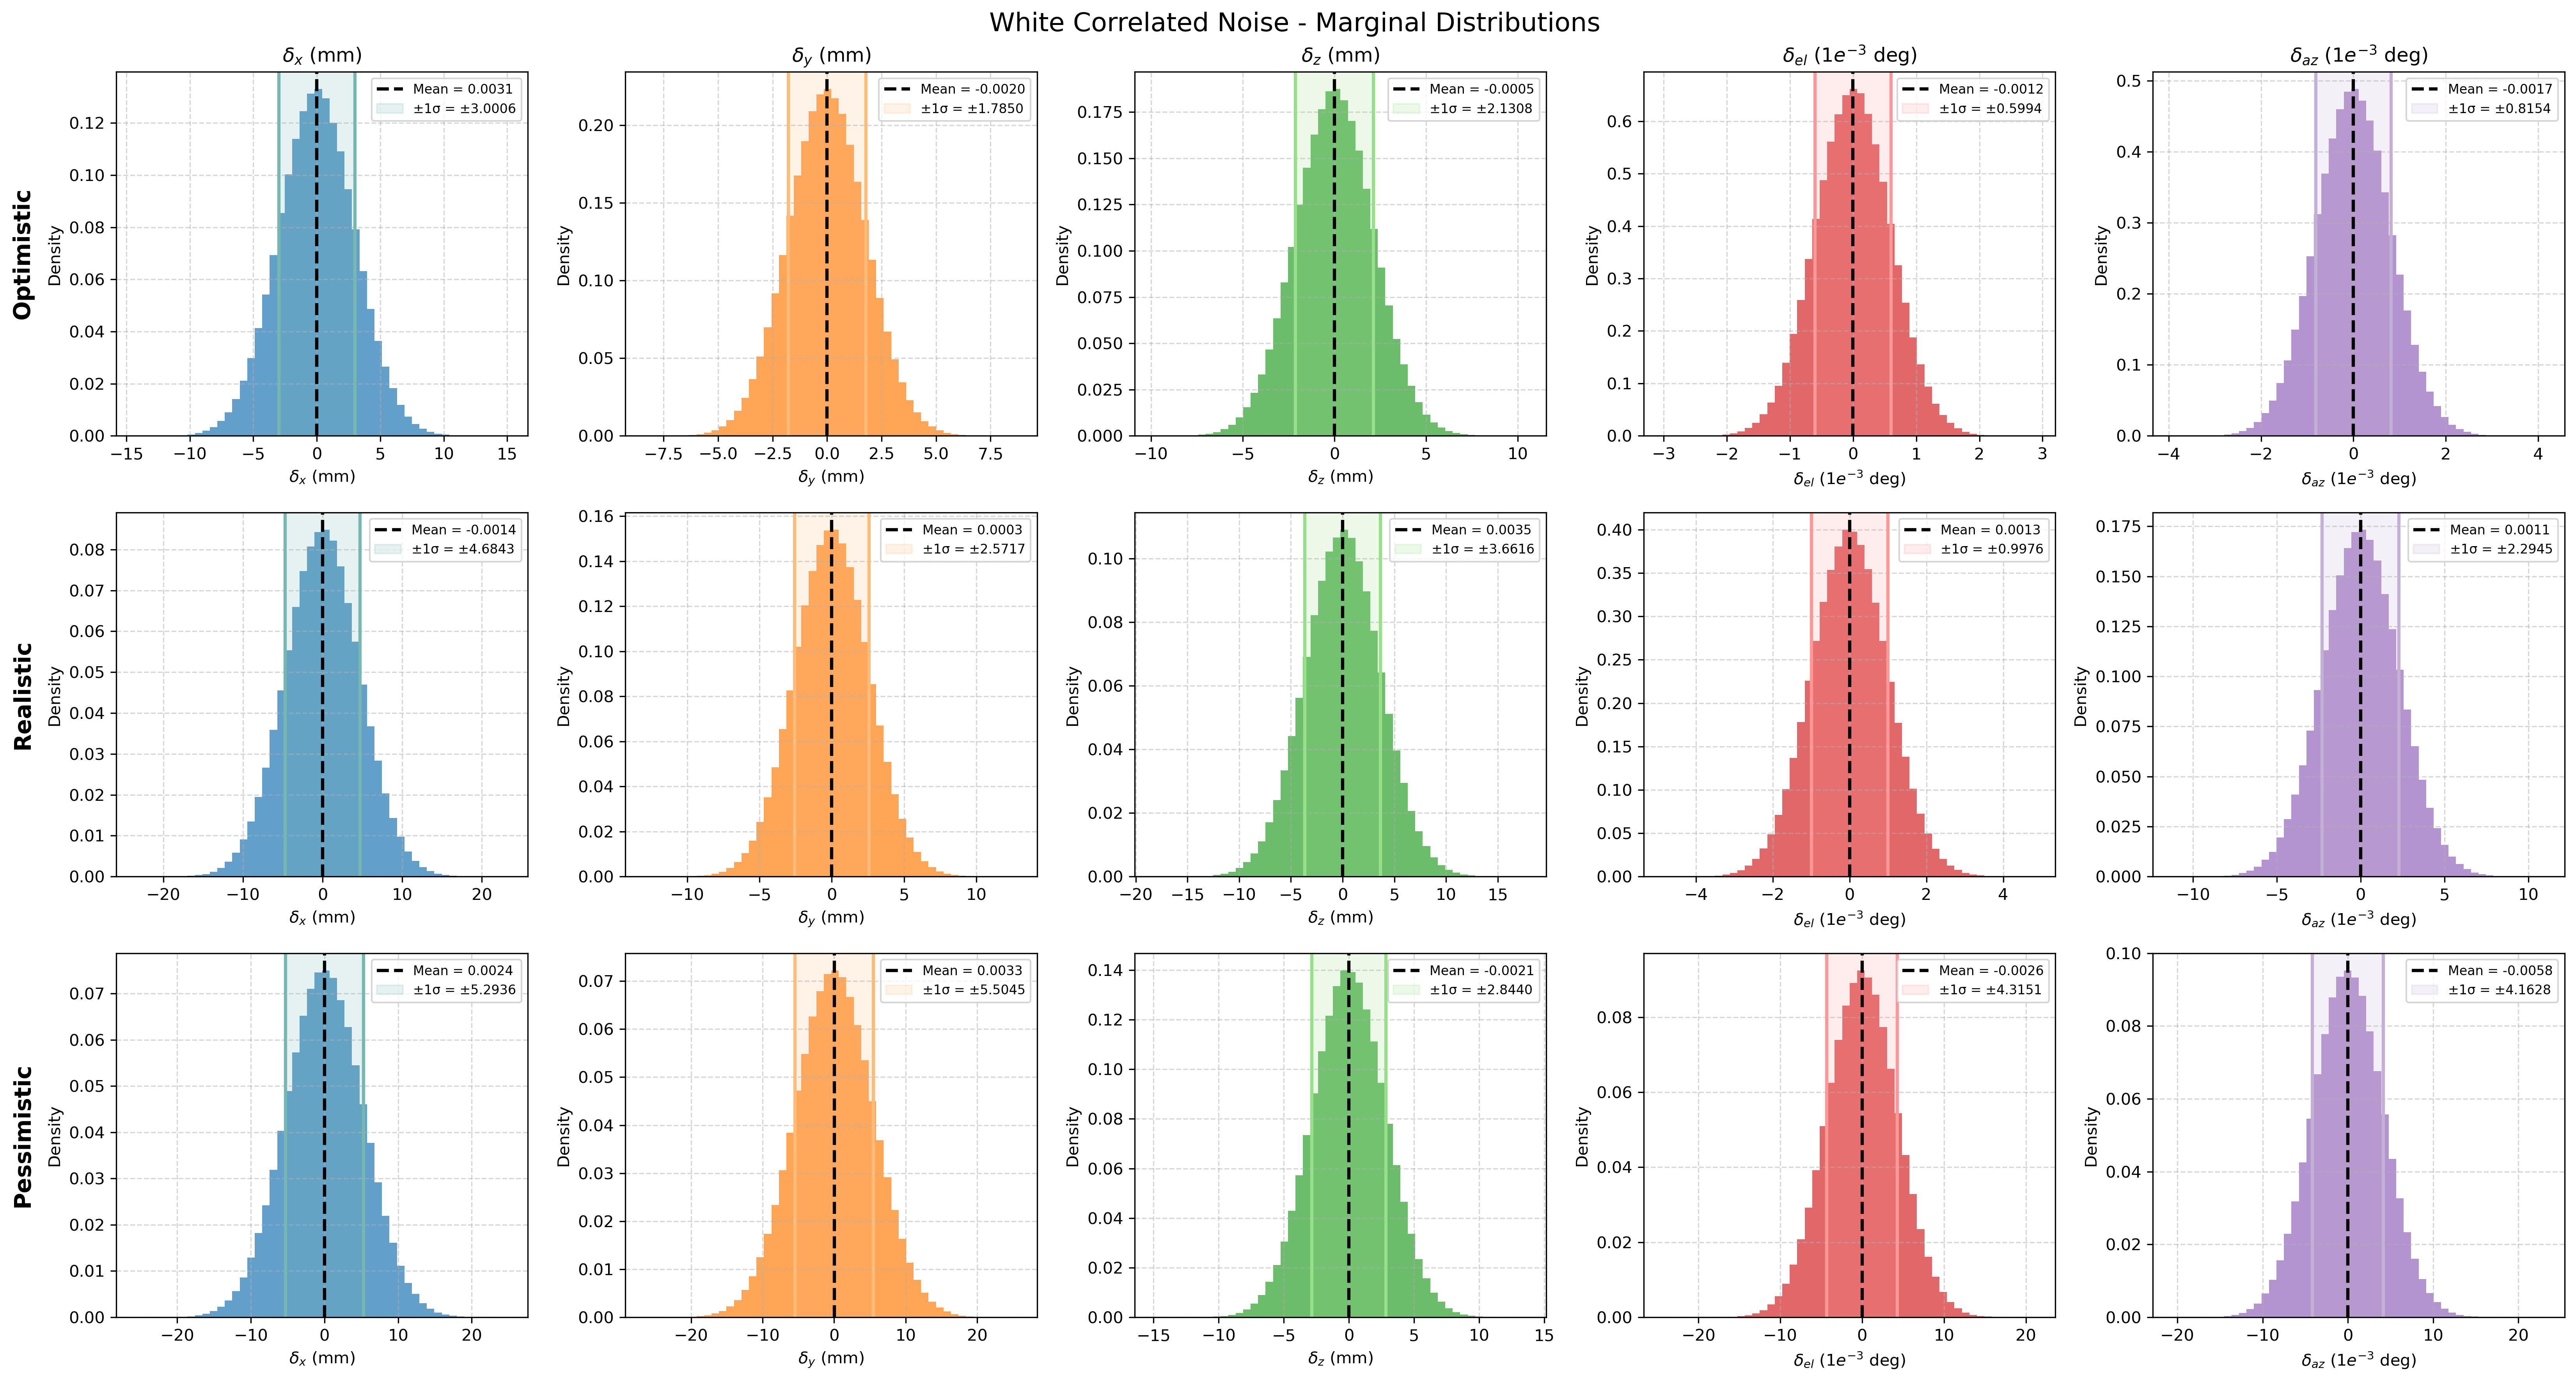

In [23]:
# White noise

fig, axes = plt.subplots(1,len(config_indices), figsize=(15, 5))
for i, config_index in enumerate(config_indices):
    for j, data_name in enumerate(data_names):
        axes[i].plot(correlated_noise_white[i][j], label=data_name + f" {round(np.std(correlated_noise_white[i][j]), 4)}", alpha=0.8, color=colors[j])
    axes[i].set_title(f"Config {name_config[i]}")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Amplitude")
    axes[i].legend()
    axes[i].set_ylim(-20, 20)
fig.suptitle("Correlated Noise - White", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(config_indices), len(data_names), figsize=(22, 12), dpi=300)
for iconfig in range(len(config_indices)):
    for i in range(5):
        ax = axes[iconfig, i]
        data = correlated_noise_white[iconfig][i]
        mean = np.mean(data)
        std = np.std(data)
        ax.hist(data, bins=50, color=colors[i], alpha=0.7, density=True)
        ax.axvline(mean, linestyle="--", color="k", linewidth=2, label=f"Mean = {mean:.4f}")
        ax.axvline(mean + std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvline(mean - std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvspan(mean - std, mean + std, color=sigma_colors[i], alpha=0.18, label=f"±1σ = ±{std:.4f}")
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Density")
        if iconfig == 0:
            ax.set_title(labels[i])
        if i == 0:
            ax.annotate(name_config[iconfig], xy=(-0.2, 0.5), xycoords='axes fraction', fontsize=14,
                        ha='right', va='center', rotation=90, fontweight='bold')
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8, loc="upper right")
fig.suptitle("White Correlated Noise - Marginal Distributions", fontsize=16)
plt.tight_layout()
plt.show()

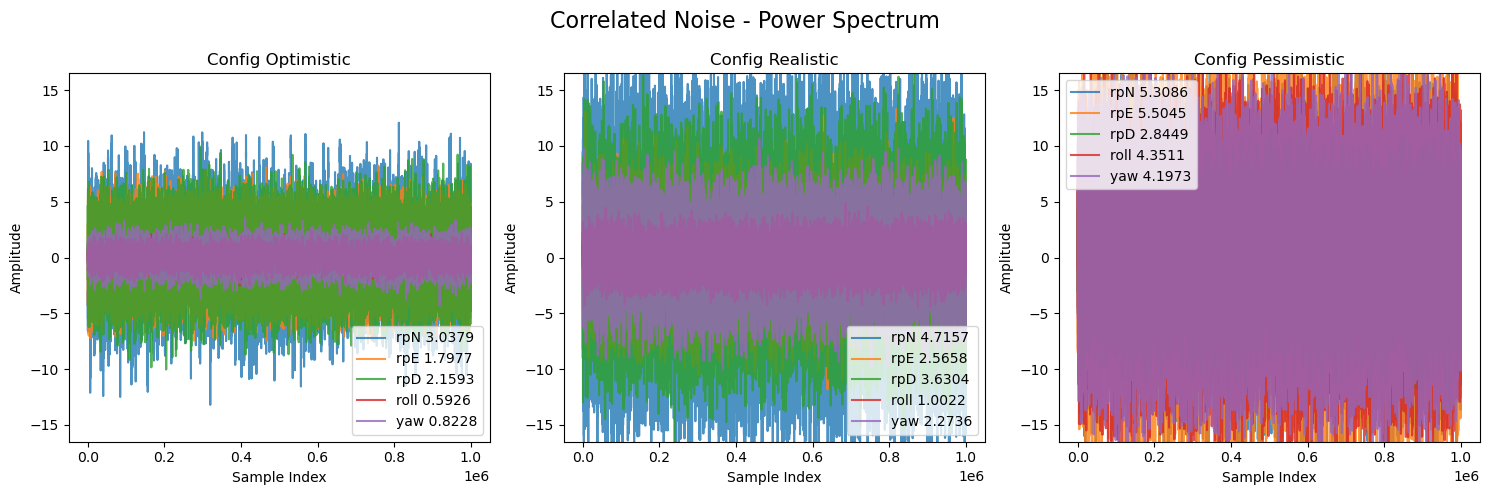

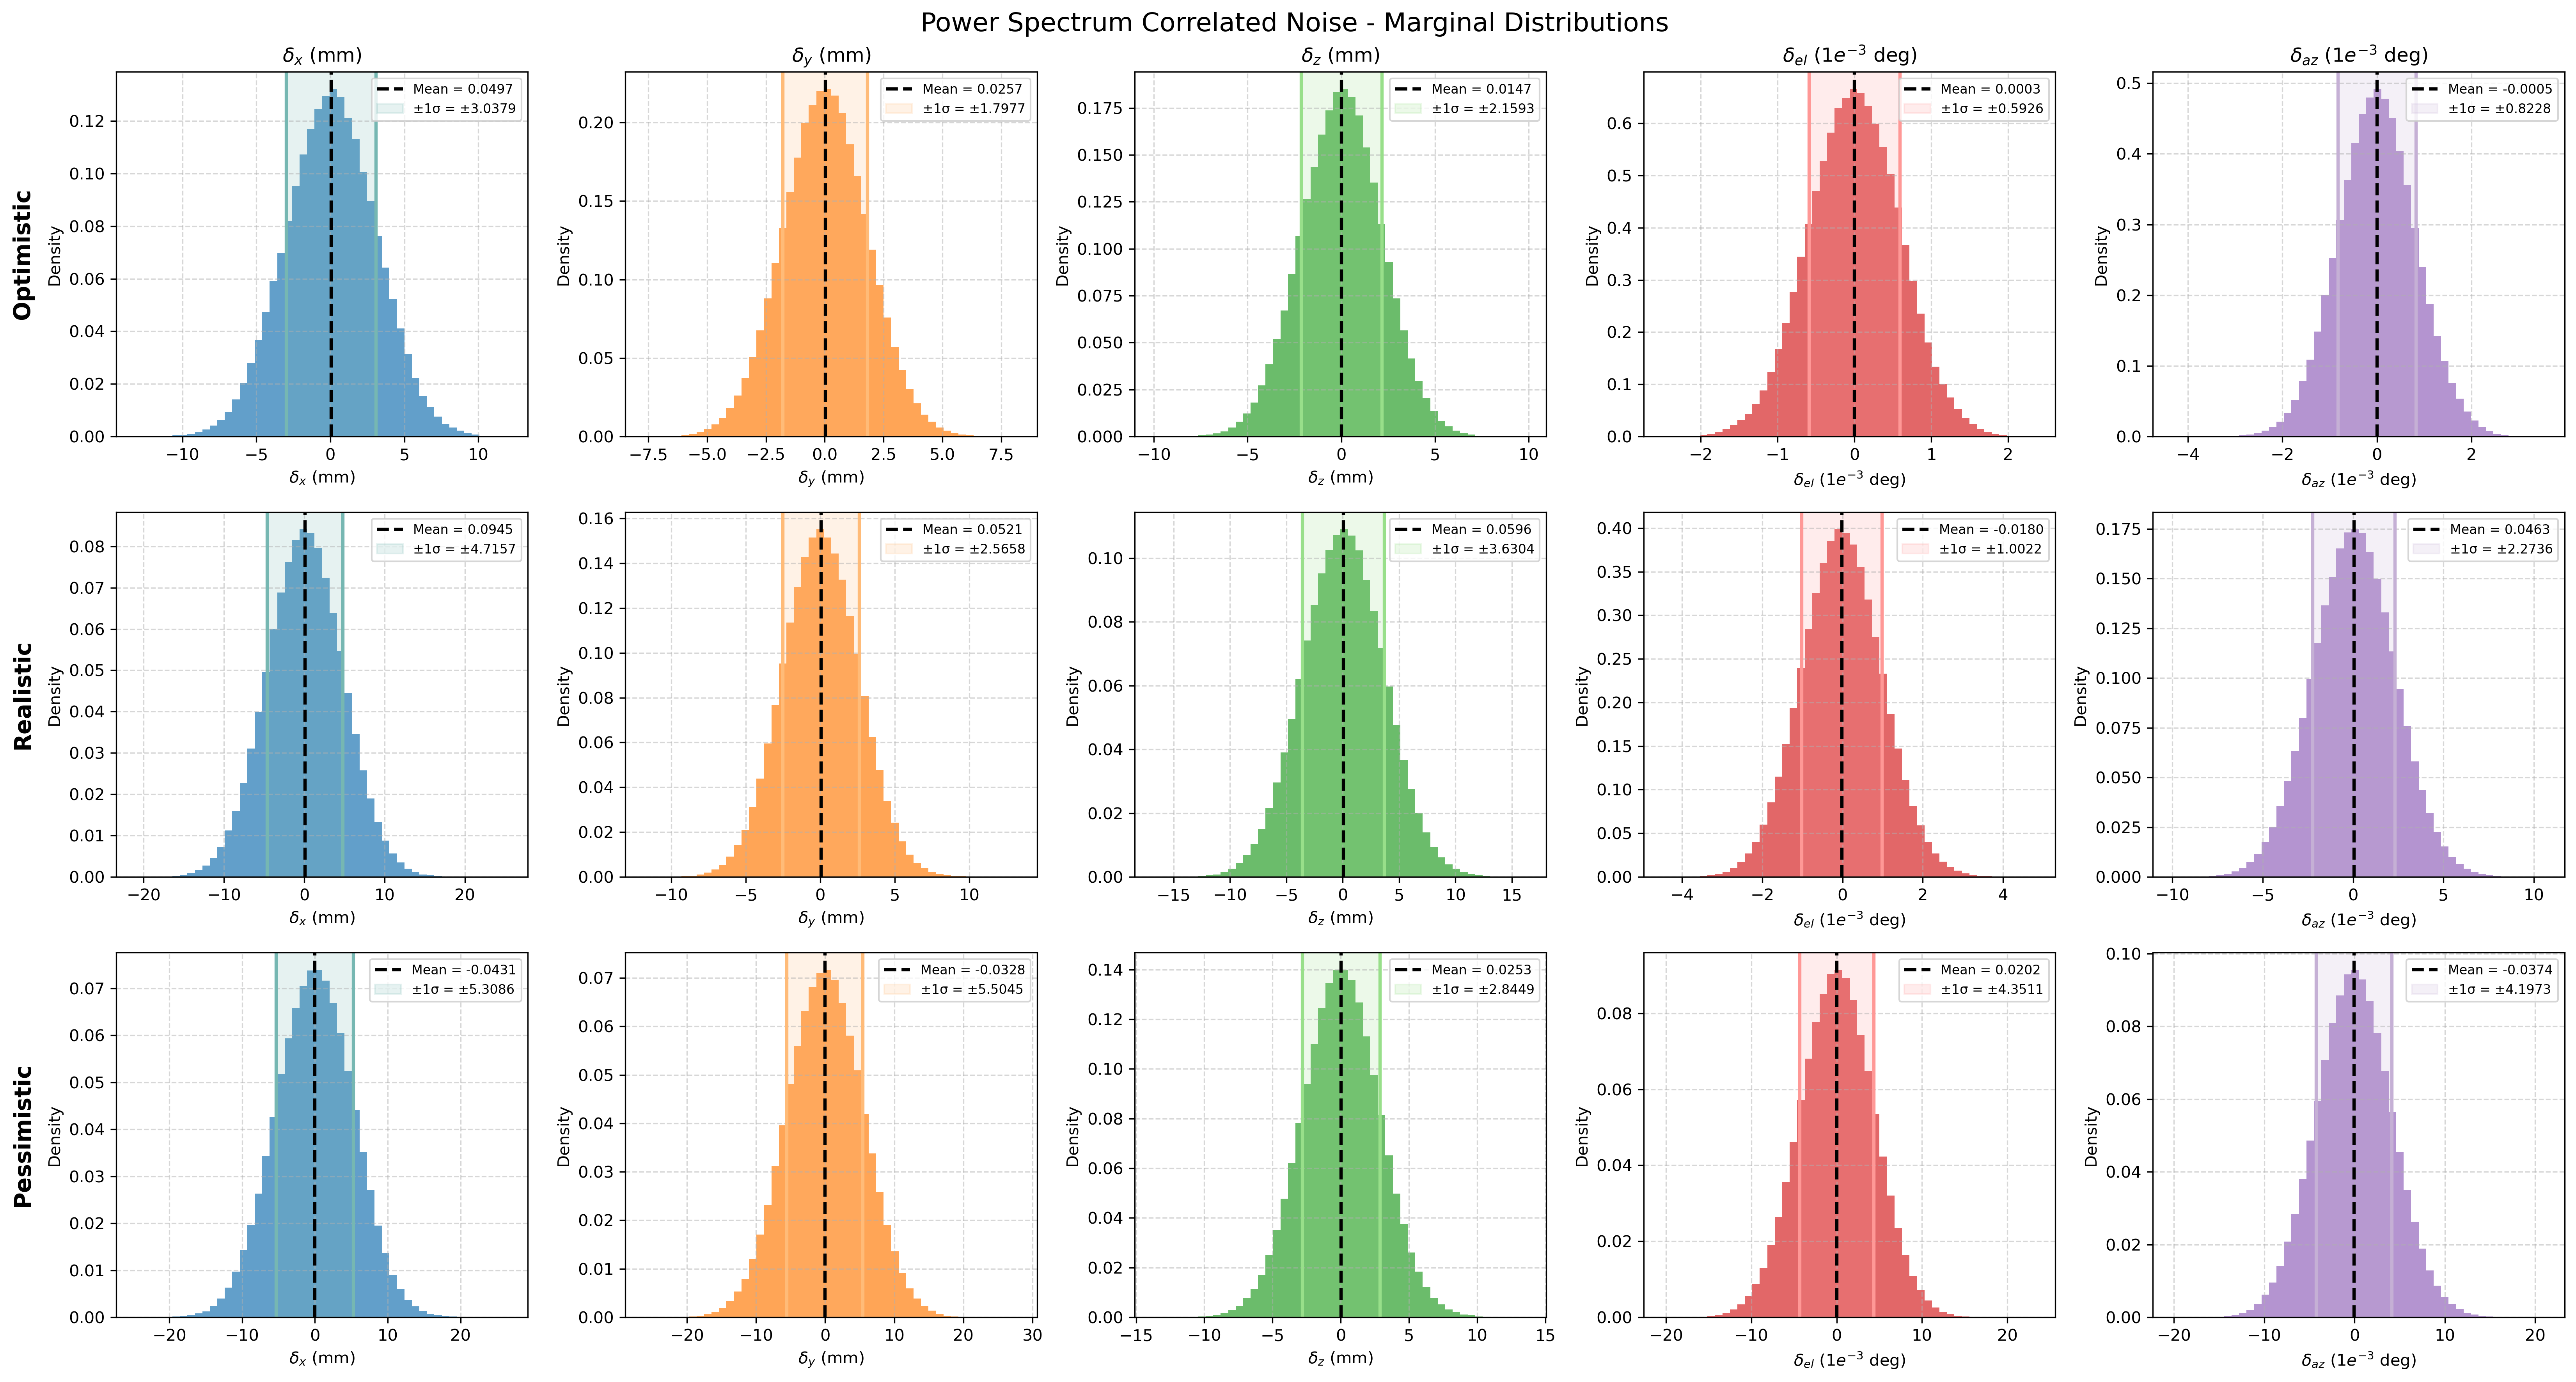

In [24]:
# PS noise

fig, axes = plt.subplots(1,len(config_indices), figsize=(15, 5))
for i, config_index in enumerate(config_indices):
    for j, data_name in enumerate(data_names):
        axes[i].plot(correlated_noise_ps[i][j], label=data_name + f" {round(np.std(correlated_noise_ps[i][j]), 4)}", alpha=0.8, color=colors[j])
    axes[i].set_title(f"Config {name_config[i]}")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Amplitude")
    axes[i].legend()
    axes[i].set_ylim(-16.5, 16.5)
fig.suptitle("Correlated Noise - Power Spectrum", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(config_indices), len(data_names), figsize=(22, 12), dpi=300)
for iconfig in range(len(config_indices)):
    for i in range(5):
        ax = axes[iconfig, i]
        data = correlated_noise_ps[iconfig][i]
        mean = np.mean(data)
        std = np.std(data)
        ax.hist(data, bins=50, color=colors[i], alpha=0.7, density=True)
        ax.axvline(mean, linestyle="--", color="k", linewidth=2, label=f"Mean = {mean:.4f}")
        ax.axvline(mean + std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvline(mean - std, linestyle="-", color=sigma_colors[i], linewidth=2)
        ax.axvspan(mean - std, mean + std, color=sigma_colors[i], alpha=0.18, label=f"±1σ = ±{std:.4f}")
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Density")
        if iconfig == 0:
            ax.set_title(labels[i])
        if i == 0:
            ax.annotate(name_config[iconfig], xy=(-0.2, 0.5), xycoords='axes fraction', fontsize=14,
                        ha='right', va='center', rotation=90, fontweight='bold')
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend(fontsize=8, loc="upper right")
fig.suptitle("Power Spectrum Correlated Noise - Marginal Distributions", fontsize=16)
plt.tight_layout()
plt.show()

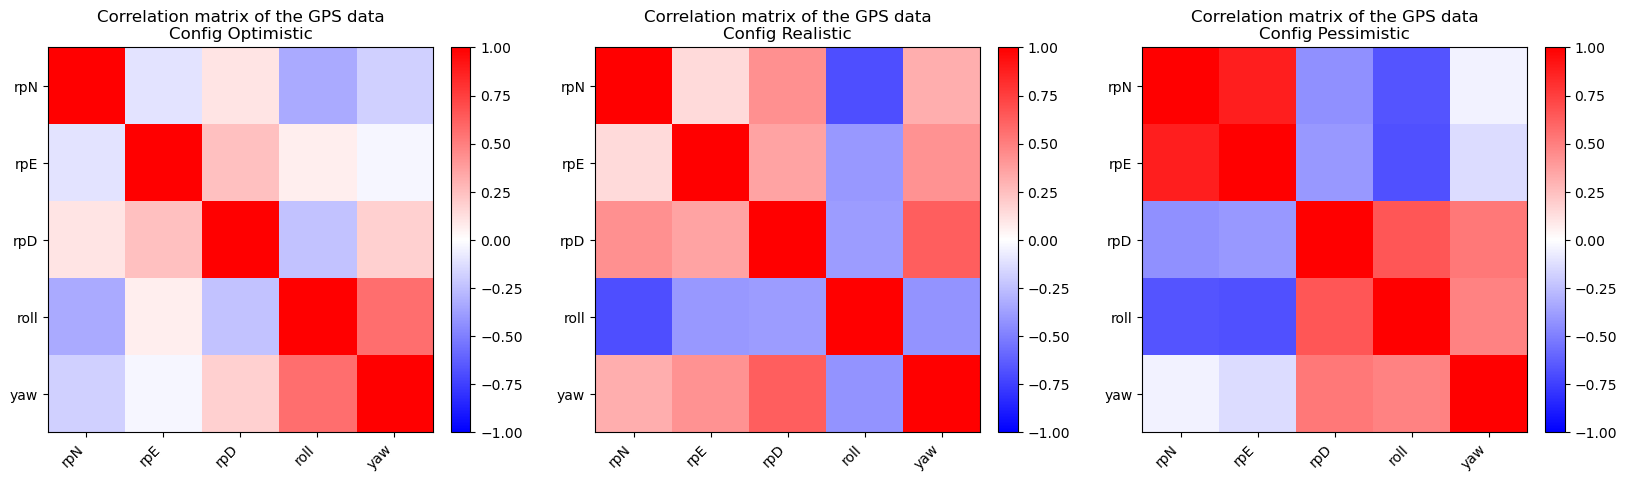

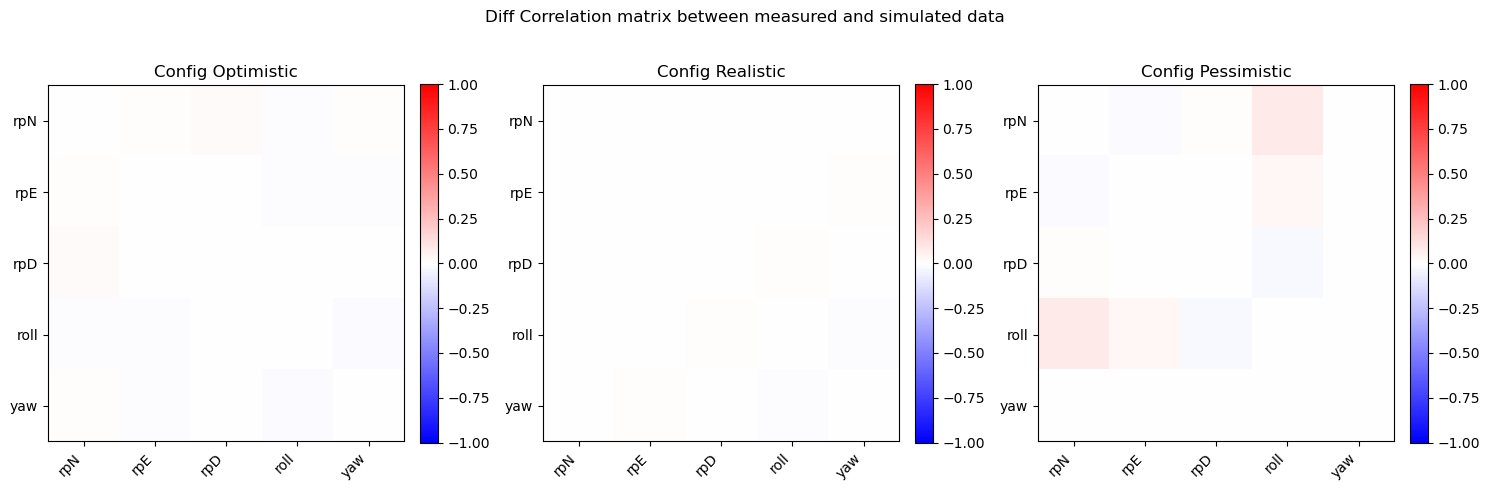

In [25]:
fig, axes = plt.subplots(1, len(config_indices), figsize=(20, 5))

fig_, axes_ = plt.subplots(1, len(name_config), figsize=(15, 5))

for i, config in enumerate(name_config):
    corr_test = np.corrcoef(correlated_noise_ps[i], rowvar=True)
    im = axes[i].imshow(corr_test, vmin=-1, vmax=1, cmap="bwr", aspect='equal')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    axes[i].set_xticks(np.arange(len(data_names)))
    axes[i].set_yticks(np.arange(len(data_names)))
    axes[i].set_xticklabels(data_names, rotation=45, ha='right')
    axes[i].set_yticklabels(data_names)
    axes[i].set_title(f"Correlation matrix of the GPS data\nConfig {config}")
    
    im = axes_[i].imshow(corr_test - corr[i], vmin=-1, vmax=1, cmap="bwr", aspect='equal')
    fig_.colorbar(im, ax=axes_[i], fraction=0.046, pad=0.04)

    axes_[i].set_xticks(np.arange(len(data_names)))
    axes_[i].set_yticks(np.arange(len(data_names)))
    axes_[i].set_xticklabels(data_names, rotation=45, ha='right')
    axes_[i].set_yticklabels(data_names)
    axes_[i].set_title(f"Config {config}")
fig_.suptitle("Diff Correlation matrix between measured and simulated data")
plt.tight_layout()
plt.show()

# MC Gaussian Noise

### 1. **Physical Context and Coordinate System**

- The calibration source emits a beam toward the QUBIC receiver.
- The **x-axis** is defined along the line joining the source and QUBIC (beam axis).
- The **z-axis** is vertical (upwards).
- The **y-axis** is horizontal and orthogonal to both x and z.

In this frame:
- **Azimuth (`az`)** is a rotation around the z-axis (vertical), causing the beam to sweep left-right (modifies y).
- **Elevation (`el`)** is a rotation around the y-axis (horizontal), causing the beam to sweep up-down (modifies z).

### 2. **Uncertainties**

- The calibration source position is uncertain in all three spatial directions: `d_x`, `d_y`, `d_z`.
- The orientation is also uncertain: `d_el` (elevation), `d_az` (azimuth).
- These uncertainties are sampled from a multivariate normal distribution.

### 3. **Propagation of Uncertainties**

#### **a. QUBIC Position Vector**

We define the QUBIC position in the source frame as:
```python
qubic_vec = np.array([distance_qubic_calsource, 0, 0])
```
This means QUBIC is located at a distance `distance_qubic_calsource` along the x-axis from the source.

#### **b. Applying Rotations**

To account for orientation uncertainties, we rotate the QUBIC vector by the sampled elevation and azimuth angles:

- **Elevation rotation (`R_el`)**: Rotates around the y-axis.
- **Azimuth rotation (`R_az`)**: Rotates around the z-axis.

The combined rotation is:
```python
R = R_az @ R_el
qubic_rot = R @ qubic_vec
```
This gives the new direction of the beam after applying the sampled orientation errors.

#### **c. Adding Position Uncertainties**

After rotation, we add the sampled position uncertainties:
```python
qubic_rot += np.array([d_x, d_y, d_z])
```
This shifts the QUBIC position according to the sampled errors.

#### **d. Calculating the Offset from the Beam Axis**

The **radial offset** from the beam axis (which is now possibly misaligned) is:
```python
delta_r = np.sqrt(qubic_rot[1]**2 + qubic_rot[2]**2)
```
This is the distance from the beam axis in the y-z plane.

The **longitudinal offset** (distance along the beam axis) is:
```python
delta_x = qubic_rot[0]
```
This is the new distance from the source along the (possibly rotated) x-axis.

#### **e. Calculating the Received Intensity**

The received intensity at QUBIC is then computed using the Gaussian beam formula:
```python
amplitudes[i] = gaussian_beam(delta_r, delta_x, w0, I0) / intensity_normalization
```
- `gaussian_beam(r, z, w0, I0)` gives the intensity at radial offset `r` and distance `z` from the source.
- We normalize by the intensity at the nominal position to get a relative amplitude.

# Plots

In [26]:
amplitudes_white = []
amplitudes_ps = []
labels_conf = []

def uncertainties_from_noise(noise): 
    d_x, d_y, d_z, d_el, d_az = noise  / 1000 # / 1000 because my noise are in mm and 1e-3 rad
    el_rad, az_rad = np.radians(d_el), np.radians(d_az)
    N_noise = len(d_x)
    
    cos_el = np.cos(el_rad)
    sin_el = np.sin(el_rad)
    cos_az = np.cos(az_rad)
    sin_az = np.sin(az_rad)

    qubic_vec = np.array([distance_qubic_calsource, 0, 0])

    x1 = qubic_vec[0] * cos_el + qubic_vec[2] * sin_el
    y1 = qubic_vec[1] * np.ones(N_noise)
    z1 = -qubic_vec[0] * sin_el + qubic_vec[2] * cos_el

    x2 = x1 * cos_az - y1 * sin_az
    y2 = x1 * sin_az + y1 * cos_az
    z2 = z1

    x_final = x2 + d_x
    y_final = y2 + d_y
    z_final = z2 + d_z

    delta_r = np.sqrt(y_final**2 + z_final**2)
    delta_x = x_final
    
    return gaussian_beam(delta_r, delta_x, w0, I0) / gaussian_beam(0, distance_qubic_calsource, w0, I0)

for iconfig in range(len(config_indices)):
    amplitudes_white.append(uncertainties_from_noise(correlated_noise_white[iconfig]))
    amplitudes_ps.append(uncertainties_from_noise(correlated_noise_ps[iconfig]))

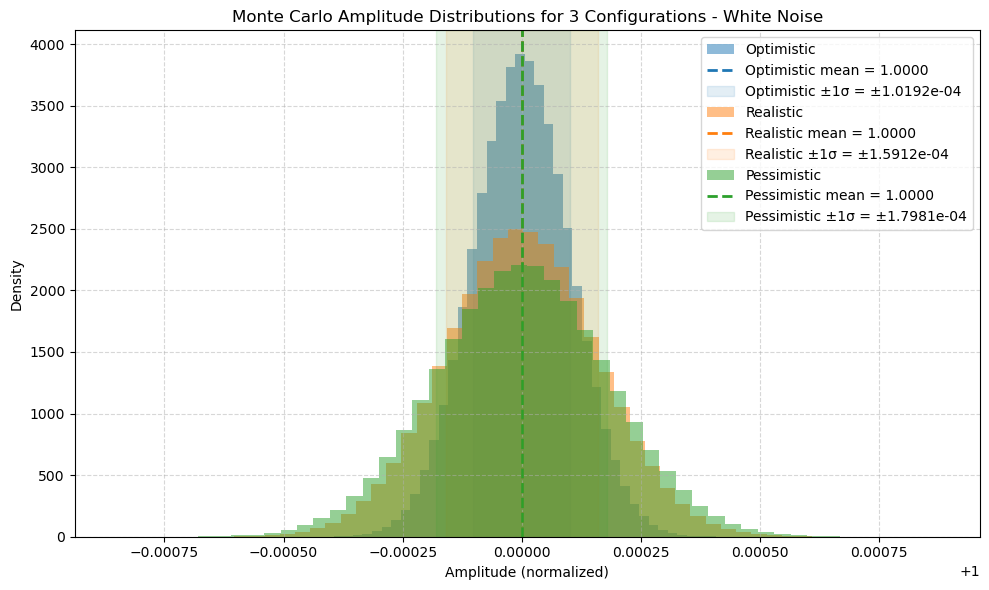

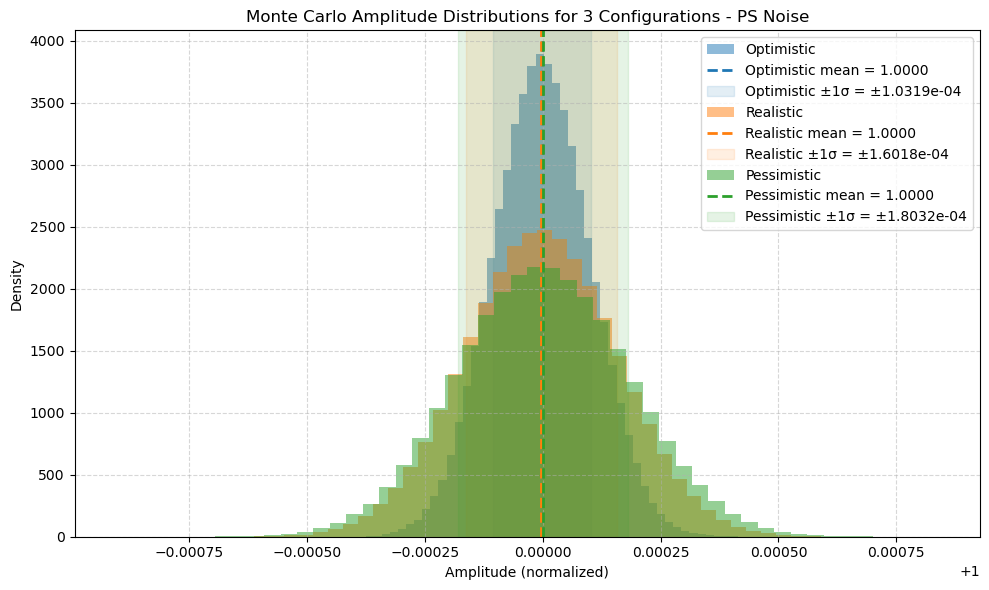

In [27]:
# Plot amplitude distributions for the 3 configurations
plt.figure(figsize=(10, 6))
colors_ = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (amplitudes, label) in enumerate(zip(amplitudes_white, name_config)):
    plt.hist(amplitudes, bins=50, density=True, alpha=0.5, color=colors[i], label=name_config[i])
    mean = np.mean(amplitudes)
    std = np.std(amplitudes)
    plt.axvline(mean, color=colors[i], linestyle='--', linewidth=2, label=f'{name_config[i]} mean = {mean:.4f}')
    plt.axvspan(mean-std, mean+std, color=colors[i], alpha=0.12, label=f'{name_config[i]} ±1σ = ±{std:.4e}')

plt.xlabel('Amplitude (normalized)')
plt.ylabel('Density')
plt.title('Monte Carlo Amplitude Distributions for 3 Configurations - White Noise')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot amplitude distributions for the 3 configurations
plt.figure(figsize=(10, 6))
colors_ = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (amplitudes, label) in enumerate(zip(amplitudes_ps, name_config)):
    plt.hist(amplitudes, bins=50, density=True, alpha=0.5, color=colors[i], label=name_config[i])
    mean = np.mean(amplitudes)
    std = np.std(amplitudes)
    plt.axvline(mean, color=colors[i], linestyle='--', linewidth=2, label=f'{name_config[i]} mean = {mean:.4f}')
    plt.axvspan(mean-std, mean+std, color=colors[i], alpha=0.12, label=f'{name_config[i]} ±1σ = ±{std:.4e}')

plt.xlabel('Amplitude (normalized)')
plt.ylabel('Density')
plt.title('Monte Carlo Amplitude Distributions for 3 Configurations - PS Noise')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()